# Fantacalcio 2025-2026
## Executive Summary

**Obiettivo:** Identificare giocatori affidabili e ad alto potenziale per l’asta Fantacalcio, basandosi su statistiche per 90 minuti e metriche avanzate.  

**Dati:** Statistiche giocatori Serie A 2024-2025 da FBref (scraping HTML).  

**Metodologia:**
- Pulizia e normalizzazione dataset
- Creazione metriche derivate (gol/90, xG/90, passaggi progressivi, ecc.)
- Calcolo di tier qualitativi (A, B, C, D) su percentili
- Visualizzazione per ruolo  

**Principali Risultati:**
- Ranking dei migliori giocatori per ruolo (Top 10 ATT, CEN, DIF, POR)
- Identificazione di alcuni giocatori “undervalued” con alto potenziale  

**Conclusione:** Il metodo permette di supportare scelte oggettive nell’asta, combinando metriche classiche e avanzate.  

# 1. Titolo & Obiettivi  
## Titolo:  
“Analisi Serie A 20XX-XX per asta fantacalcio”
## Obiettivo:  
“Selezionare giocatori affidabili e con alto potenziale, usando metriche per 90’ e filtri di robustezza.”

## 2. Dati & Dizionario variabili  
I dati sono stati forniti da FBref e salvati in locale

In [1]:
import lxml
import pandas as pd
import numpy as np
from io import StringIO
from bs4 import BeautifulSoup as bs, Comment
import re
import matplotlib.pyplot as plt
import mplcursors
import os
import re, unicodedata

## 3.	Import & Caricamento dati (breve)

In [2]:
#   Apro il file in locale
with open('Dati/2024-2025 Serie A Player Stats | FBref.com.html') as source:
    content = source.read()
    soup = bs(content, 'lxml')
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    tables_html = [c for c in comments if "<table" in c]
    table_html = tables_html[0]
    data_soup = bs(table_html, 'lxml')
# Estraggo dal file un data frame
df_player_raw = pd.read_html(StringIO(table_html))[0]
# Flatto gli headers
df_player_raw.columns = ["_".join(col).strip() if isinstance(col, tuple) else col
              for col in df_player_raw.columns.values]

## 4.	Pulizia & Controlli qualità

In [3]:
# Creo un dataframe da quello grezzo
df_player = df_player_raw
# Elimino le colonne inutili
df_player = df_player.drop(columns=[
    'Unnamed: 0_level_0_Rk', 
    'Unnamed: 6_level_0_Born', 
    'Playing Time_90s',
    'Performance_G+A', 
    'Performance_G-PK',
    'Expected_npxG+xAG', 
    'Per 90 Minutes_Gls', 
    'Per 90 Minutes_Ast',
    'Per 90 Minutes_G+A', 
    'Per 90 Minutes_G-PK', 
    'Per 90 Minutes_G+A-PK',
    'Per 90 Minutes_xG', 
    'Per 90 Minutes_xAG', 
    'Per 90 Minutes_xG+xAG',
    'Per 90 Minutes_npxG', 
    'Per 90 Minutes_npxG+xAG',
    'Unnamed: 36_level_0_Matches'])
# Rinomino le colonne in maniera leggibile
df_player = df_player.rename(columns={
    'Unnamed: 1_level_0_Player' : 'player',
    'Unnamed: 2_level_0_Nation' : 'nation', 
    'Unnamed: 3_level_0_Pos' : 'pos',
    'Unnamed: 4_level_0_Squad' : 'team', 
    'Unnamed: 5_level_0_Age' : 'age',
    'Playing Time_MP' : 'matches', 
    'Playing Time_Starts' : 'starts',
    'Playing Time_Min' : 'minutes', 
    'Performance_Gls' : 'goals',
    'Performance_Ast' : 'assists', 
    'Performance_PK' : 'pen_scored', 
    'Performance_PKatt' : 'pen_attempted', 
    'Performance_CrdY' : 'yellow_c',
    'Performance_CrdR' : 'red_c', 
    'Expected_xG' : 'exp_goals', 
    'Expected_npxG' : 'exp_non_pen_goals', 
    'Expected_xAG' : 'exp_assists',
    'Progression_PrgC' : 'prog_w_ball', 
    'Progression_PrgP' : 'prog_w_pass',
    'Progression_PrgR' : 'pass_rec_prog'
})
# Elimino le divisorie nella tabella
df_player = df_player[df_player["player"] != "Player"]
# Elimino i giocatori con il nome nullo
df_player = df_player[df_player["player"].notna()]
# Pulisco i nomi dagli spazi
cols_to_clean = ["player", "team", "nation"]
df_player[cols_to_clean] = df_player[cols_to_clean].apply(lambda x: x.str.strip().str.replace(r"\s+", " ", regex=True))
# Correggo i dati NaN in 0
df_player = df_player.fillna(0)

# Elenco le colonne numeriche
numeric_cols = [
    'age', 
    'matches', 
    'starts', 
    'minutes',
    'goals',
    'assists', 
    'pen_scored', 
    'pen_attempted', 
    'yellow_c',
    'red_c', 
    'exp_goals', 
    'exp_non_pen_goals', 
    'exp_assists',
    'prog_w_ball', 
    'prog_w_pass',
    'pass_rec_prog'
] 

for col in numeric_cols:
    if col in df_player.columns:
        df_player[col] = pd.to_numeric(df_player[col], errors="coerce")

for col in numeric_cols:
    if col in df_player.columns:
        df_player[col] = df_player[col].fillna(0)

# Filtro le posizioni e le riscrivo come POR, DIF, CEN, ATT
df_player["pos_clean"] = df_player["pos"].str.split(",").str[0]
mapping = {
    "GK": "P",
    "DF": "D",
    "MF": "C",
    "FW": "A"
}
df_player["pos"] = df_player["pos_clean"].map(mapping)

df_player_agg = (
    df_player.groupby("player", as_index=False)
      .agg({
          "nation": "first",
          "pos": "first",
          "team": lambda x: ",".join(set(x)), 
          "age": "first",
          "matches": "sum",
          "starts": "sum",
          "minutes": "sum",
          "goals": "sum",
          "assists": "sum",
          "yellow_c": "sum",
          "red_c": "sum",
          "pen_scored": "sum",
          "pen_attempted": "sum",
          "exp_goals": "sum",
          "exp_assists": "sum",
          "prog_w_ball": "sum",
          "prog_w_pass": "sum",
          "pass_rec_prog": "sum"
      })
)

df_player_agg["player"] = df_player_agg["player"].apply(
    lambda x: " ".join(x.split()[1:]) if len(x.split()) > 1 else x
)

### 5.	Feature engineering (metriche per 90’ & derivate)  
Definisco le metriche interessanti:
- <strong>Prima scelta</strong> (first_ch): partite dall'inizio / partite giocate
- <strong>Titolare</strong> (first_pl): partite dall'inizio / 38
- <strong>Presenza</strong> (pres): minuti giocati / partite giocate
- <strong>Novanta minuti</strong> (nineties): minuti giocati / 90
- <strong>Goal per 90 minuti</strong> (g90): goals / novanta minuti
- <strong>Goal su azione per 90 minuti</strong> (g_pen90): goals - rigori / novanta minuti
- <strong>Goal attesi per 90 minuti</strong> (xg90): expected goals / novanta minuti
- <strong>Delta Goals con Goals attesi</strong> (delta_g_xg): goals - expected goals
- <strong>Assist per 90 minuti</strong> (a90): assist / novanta minuti
- <strong>Assist attesi per 90 minuti</strong> (xa90): expected assist / novanta minuti
- <strong>Delta Assists con Assists attesi</strong> (delta_a_xa): assists - expected assist
- <strong>Goal + Assist per 90 minuti</strong> (ga90): goals + assist / novanta minuti
- <strong>Goal + Assist attesi per 90 minuti</strong> (xgxa90): goals attesi + assist attesi / novanta minuti
- <strong>Affidabilità goal</strong> (xGg): goals / expected goals
- <strong>Affidabilità goal su azione</strong> (xGg_pen): goals - rigori/ expected goals
- <strong>Affidabilità assist</strong> (xAa): assists / expected assists
- <strong>Cartellini gialli per 90 minuti</strong> (yc90): ammonizioni / novanta minuti
- <strong>Cartellini rossi per 90 minuti</strong> (rc90): espulsioni / novanta minuti
- <strong>Disciplina per 90 minuti</strong> (c90): ammonizioni+espulsioni / novanta minuti
- <strong>Abilità rigori</strong> (pen_rate): rigori segnati / rigori totali
- <strong>Propensione a spingere</strong> (prg_c90): progressione con palla / novanta minuti
- <strong>Propensione a crossare</strong> (prg_p90): progressione con passaggio / novanta minuti
- <strong>Propensione a ricevere</strong> (prg_r90): passaggi ricevuti in progressione / novanta minuti

In [4]:
df = df_player_agg.copy()
# Gestisco le eccezioni
def safe_divide(num: pd.Series, den: pd.Series, default=np.nan) -> pd.Series:
    """
    Divide due Serie pandas in modo sicuro.
    
    Args:
        num (pd.Series): numeratore
        den (pd.Series): denominatore
        default (float): valore restituito in caso di divisione per zero
    
    Returns:
        pd.Series: risultato della divisione
    """
    res = num / den
    res = res.replace([np.inf, -np.inf], default)
    return res.fillna(default)
# Se la metrica ha denominatore 0, restituisce 0
def per90_count(x: pd.Series, denom: pd.Series) -> pd.Series:
    return safe_divide(x, denom, default=0.0)
# Se la metrica ha denominatore 0, restituisce NaN
def per90_rate(x: pd.Series, denom: pd.Series) -> pd.Series:
    return safe_divide(x, denom, default=np.nan)

# Definisco le metriche interessanti
# Prima scelta (first_ch): partite dall'inizio / partite giocate
df["first_ch"] = safe_divide(df["starts"], df["matches"])
# Titolare (first_pl): partite dall'inizio / 38
SERIE_A_MATCHES = 38
df["first_pl"] = df["starts"] / SERIE_A_MATCHES
# Presenza (pres): minuti giocati / partite giocate
df["pres"] = safe_divide(df["minutes"], df["matches"])
# Novanta minuti (nineties): minuti giocati / 90
MATCH_TIME = 90
df["nineties"] = df["minutes"] / MATCH_TIME
# Goal per 90 minuti (g90): goals / novanta minuti
df["g90"] = per90_count(df["goals"], df["nineties"])
# Goal su azione per 90 minuti (g-pen90): goals - rigori / novanta minuti
df["g_pen90"] = per90_count((df["goals"] - df["pen_scored"]), df["nineties"])
# Goal attesi per 90 minuti (xg90): expected goals / novanta minuti
df["xg90"] = per90_rate(df["exp_goals"], df["nineties"])
#Delta Goals con Goals attesi (delta_g_xg): goals - expected goals
df["delta_g_xg"] = df["goals"] - df["exp_goals"]
# Assist per 90 minuti (a90): assist / novanta minuti
df["a90"] = per90_count(df["assists"], df["nineties"])
# Assist attesi per 90 minuti (xa90): expected assist / novanta minuti
df["xa90"] = per90_rate(df["exp_assists"], df["nineties"])
# Goal + Assist per 90 minuti (ga90): goals + assist / novanta minuti
df["ga90"] = per90_count((df["goals"] + df["assists"]), df["nineties"])
# Delta Assists con Assists attesi (delta_a_xa): assists - expected assists
df["delta_a_xa"] = df["assists"] - df["exp_assists"]
# Goal + Assist attesi per 90 minuti (xgxa90): goals attesi + assist attesi / novanta minuti
df["xgxa90"] = per90_rate((df["exp_goals"] + df["exp_assists"]), df["nineties"])
# Affidabilità goal (xGg): goals / expected goals
df["xGg"] = safe_divide(df["goals"], df["exp_goals"])
# Affidabilità goal su azione(xGg-pen): goals - rigori/ expected goals
df["xGg_pen"] = safe_divide((df["goals"] - df["pen_scored"]), df["exp_goals"])
# Affidabilità assist (xAa): assists / expected assists
df["xAa"] = safe_divide(df["assists"], df["exp_assists"])
# Cartellini gialli per 90 minuti (yc90): ammonizioni / novanta minuti
df["yc90"] = per90_count(df["yellow_c"], df["nineties"])
# Cartellini rossi per 90 minuti (rc90): espulsioni / novanta minuti
df["rc90"] = per90_count(df["red_c"], df["nineties"])
# Disciplina per 90 minuti (c90): ammonizioni+espulsioni / novanta minuti
df["c90"] = per90_count((df["yellow_c"] + df["red_c"]), df["nineties"])
# Abilità rigori (pen_rate): rigori segnati / rigori totali
df["pen_rate"] = safe_divide(df["pen_scored"], df["pen_attempted"])
# Propensione a spingere (prg_c90): progressione con palla / novanta minuti
df["prg_c90"] = per90_count(df["prog_w_ball"], df["nineties"])
# Propensione a crossare (prg_p90): progressione con passaggio / novanta minuti
df["prg_p90"] = per90_count(df["prog_w_pass"], df["nineties"])
# Propensione a ricevere (prg_r90): passaggi ricevuti in progressione / novanta minuti
df["prg_r90"] = per90_count(df["pass_rec_prog"], df["nineties"])

## 6.	Analisi per ruolo (ATT, CEN, DIF, POR)

In [5]:
# Filtra per giocatori con presenze significative
df_900 = df[(df["minutes"] >= 90) | (df["matches"] >= 2)].copy()

# Definisci Tier per metriche
def grade_from_pct(p):
    if pd.isna(p): return np.nan
    if p >= 0.90: return "S"
    if p >= 0.75: return "A"
    if p >= 0.50: return "B"
    return "C"

# Assegna i voti sul base del percentile
group_key = "pos"

def grade_metric(df_in, col, higher_is_better=True):
    '''
    Dato un dataframe, verifica le colonne se sono positive (higher_is_better=True) 
    o negative (higher_is_better=False).
    Poi per ogni colonna crea una colonna voto (_grade) e punti (_pts).
    Con il metodo grade_from_pct assegna un voto che poi tramuta in punti.
    '''
    df_in = df_in.copy()
    if group_key and group_key in df_in.columns:
        if higher_is_better:
            pct = df_in.groupby(group_key)[col].rank(pct=True, ascending=False)
        else:
            pct = df_in.groupby(group_key)[col].rank(pct=True, ascending=True)
    else:
        pct = df_in[col].rank(pct=True, ascending=not higher_is_better)

    grade_col = f"{col}_grade"
    pts_col   = f"{col}_pts"
    df_in[grade_col] = pct.apply(grade_from_pct)
    # S=3, A=2, B=1, C=0
    df_in[pts_col] = df_in[grade_col].map({"S":3, "A":2, "B":1, "C":0})
    return df_in
# Calcola il voto sintetico sulla base della media ponderata dei parametri
def synthetic_grade(df_in: pd.DataFrame, weights: dict, out_col: str = "synthetic_index") -> pd.DataFrame:
    """
    Calcola un indice sintetico come media ponderata delle colonne *_pts.
    - df_in: DataFrame con colonne tipo 'ga90_pts', 'xa90_pts', ...
    - weights: dict { 'ga90': 2.0, 'xg90': 1.5, ... } (pesi >=0)
    - out_col: nome della colonna di output
    """
    df_out = df_in.copy()
    acc = 0.0
    wsum = 0.0

    for m, w in weights.items():
        col = f"{m}_pts"
        if col in df_out.columns:
            try:
                w = float(w)
            except (TypeError, ValueError):
                continue
            if w == 0:
                continue
            acc  = acc  + df_out[col].fillna(0) * w
            wsum = wsum + w

    df_out[out_col] = np.nan if wsum == 0 else acc / wsum
    df_out["score_0_100"]  = (df_out[out_col] / 3 * 100).round(1)
    return df_out

# Applica pesi per ruolo
def apply_role_weights(g: pd.DataFrame) -> pd.DataFrame:
    w = weights_by_role.get(g.name, default_weights)  
    return synthetic_grade(g, w, out_col="score_mean_w")
    
# Metriche positive
metrics_H = [
    "first_ch", "first_pl", "pres", 
    "prg_c90", "prg_p90", "prg_r90", 
    "xGg_pen", "g_pen90", "g90", "a90", "ga90", "pen_rate",
    "xg90", "xa90", "xgxa90",
    "delta_g_xg", "delta_a_xa"
]
# Metriche negative
metrics_l = [
    "c90", "rc90", "yc90"
]

# Peso metriche per determinare voto finale per difensori
weights_dif = {
    "first_ch": 0.75, 
    "first_pl": 0.75, 
    "pres": 0.75, 
    "prg_c90": 0.75, 
    "prg_p90": 0.75, 
    "prg_r90": 0.25, 
    "xGg_pen": 0.25, 
    "g_pen90": 0.25, 
    "g90": 0.5, 
    "a90": 0.5, 
    "ga90": 0.5, 
    "pen_rate": 0.25,
    "xg90": 0.5, 
    "xa90": 0.5, 
    "xgxa90": 0.5,
    "delta_g_xg": 0.25, 
    "delta_a_xa": 0.25,
    "c90": 0.75, 
    "rc90": 0.75, 
    "yc90": 0.75
}

# Peso metriche per determinare voto finale centrocampisti
weights_cen = {
    "first_ch": 0.75, 
    "first_pl": 0.75, 
    "pres": 0.75, 
    "prg_c90": 0.75, 
    "prg_p90": 0.75, 
    "prg_r90": 0.75, 
    "xGg_pen": 0.5, 
    "g_pen90": 0.5, 
    "g90": 0.75, 
    "a90": 0.75, 
    "ga90": 0.75, 
    "pen_rate": 0.5,
    "xg90": 0.5, 
    "xa90": 0.5, 
    "xgxa90": 0.5,
    "delta_g_xg": 0.5, 
    "delta_a_xa": 0.5,
    "c90": 0.5, 
    "rc90": 0.5, 
    "yc90": 0.5
}
# Peso metriche per determinare voto finale attaccanti
weights_att = {
    "first_ch": 0.75, 
    "first_pl": 0.75, 
    "pres": 0.75, 
    "prg_c90": 0.25, 
    "prg_p90": 0.25, 
    "prg_r90": 0.75, 
    "xGg_pen": 0.75, 
    "g_pen90": 0.75, 
    "g90": 0.75, 
    "a90": 0.25, 
    "ga90": 0.5, 
    "pen_rate": 0.75,
    "xg90": 0.75, 
    "xa90": 0.25, 
    "xgxa90": 0.5,
    "delta_g_xg": 0.75, 
    "delta_a_xa": 0.25,
    "c90": 0.5, 
    "rc90": 0.5, 
    "yc90": 0.5
}

for m in metrics_H:
    df_900 = grade_metric(df_900, m, higher_is_better=True)

for m in metrics_l:
    df_900 = grade_metric(df_900, m, higher_is_better=False)

weights_by_role = {
    "D": weights_dif,
    "C": weights_cen,
    "A": weights_att,
}
default_weights = weights_cen

df_rank = (
    df_900.groupby("pos")
          .apply(lambda g: apply_role_weights(g).assign(pos=g.name),
                 include_groups=False)
          .reset_index(drop=True)
)

# percentile per ruolo (alto = meglio)
df_rank["score_pct_role"] = (
    df_rank.groupby("pos")["score_mean_w"].rank(pct=True, ascending=False)
)

# mappa percentili → S/A/B/C (0–0.5 C, 0.5–0.75 B, 0.75–0.9 A, ≥0.9 S)
df_rank["tier_overall"] = pd.cut(
    df_rank["score_pct_role"],
    bins=[0, 0.50, 0.75, 0.90, 1.00],
    labels=["C","B","A","S"],
    include_lowest=True, right=True
)


## 7.	Grafici principali

In [6]:
dfv = df_rank.copy()

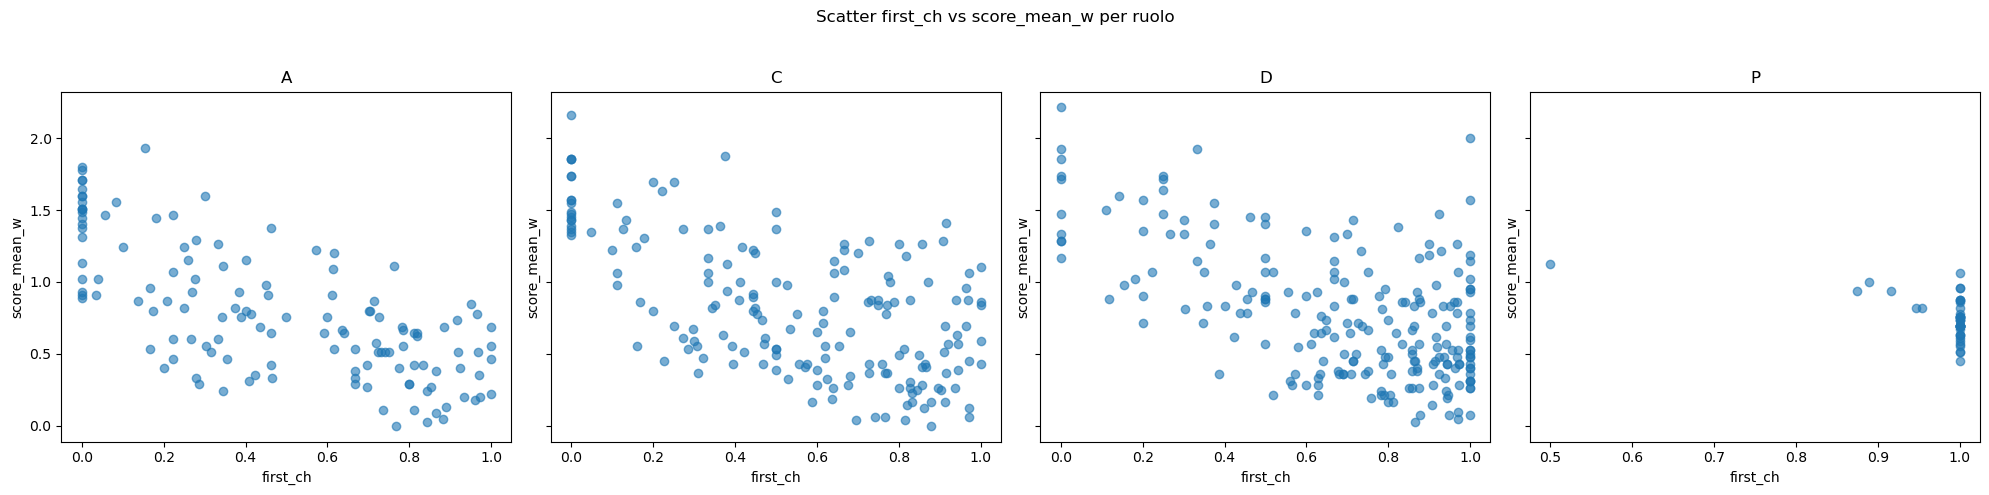

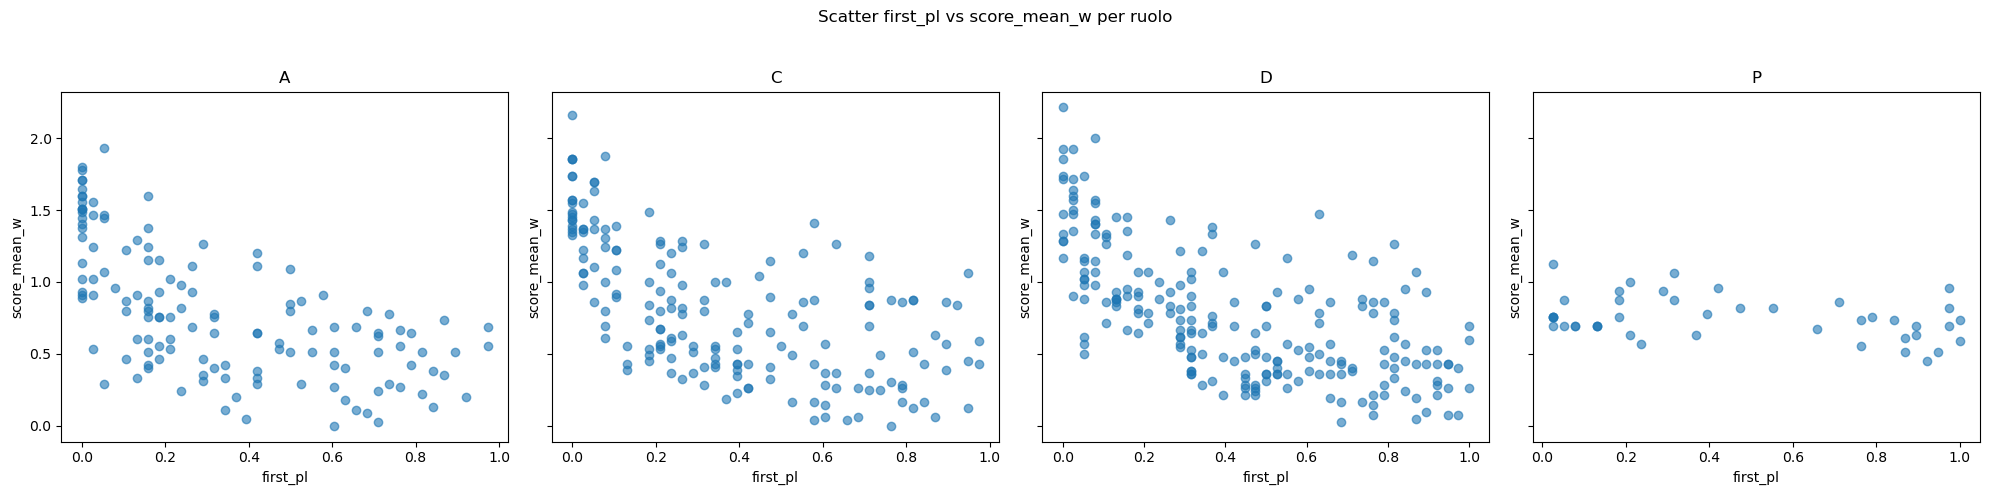

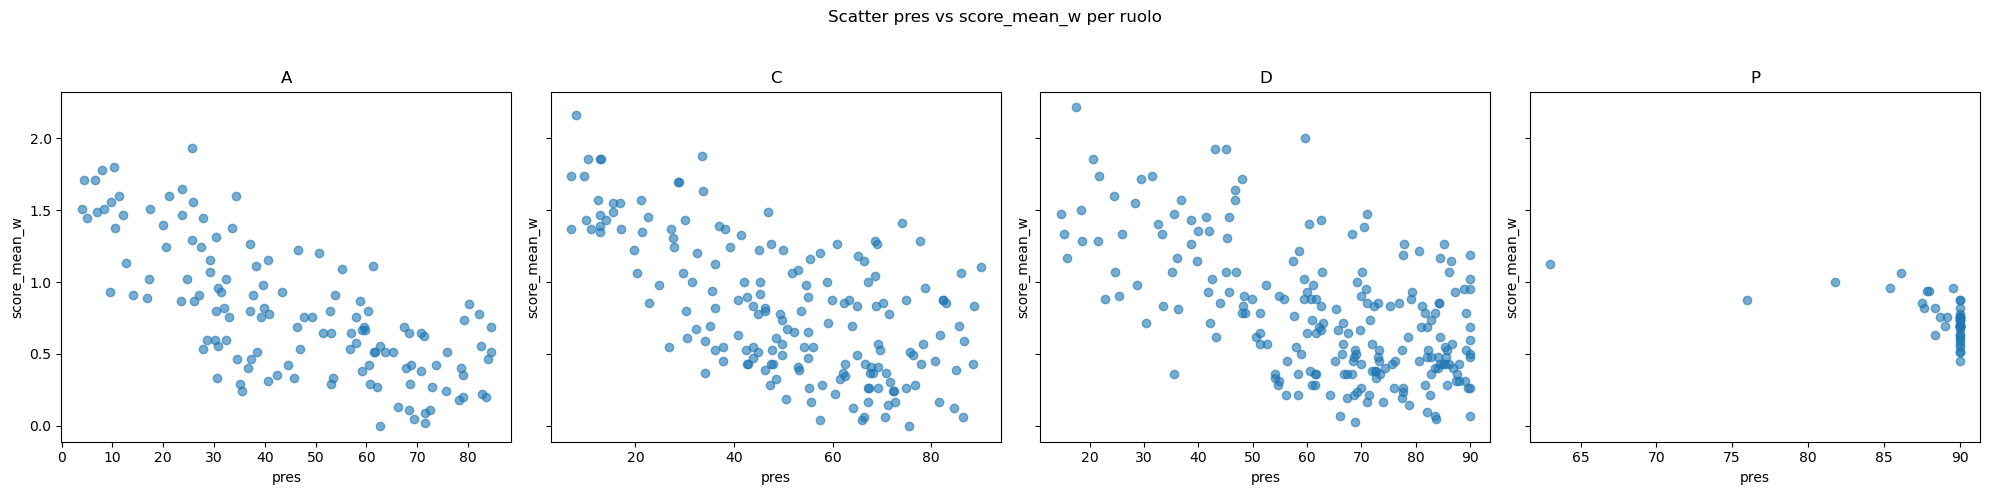

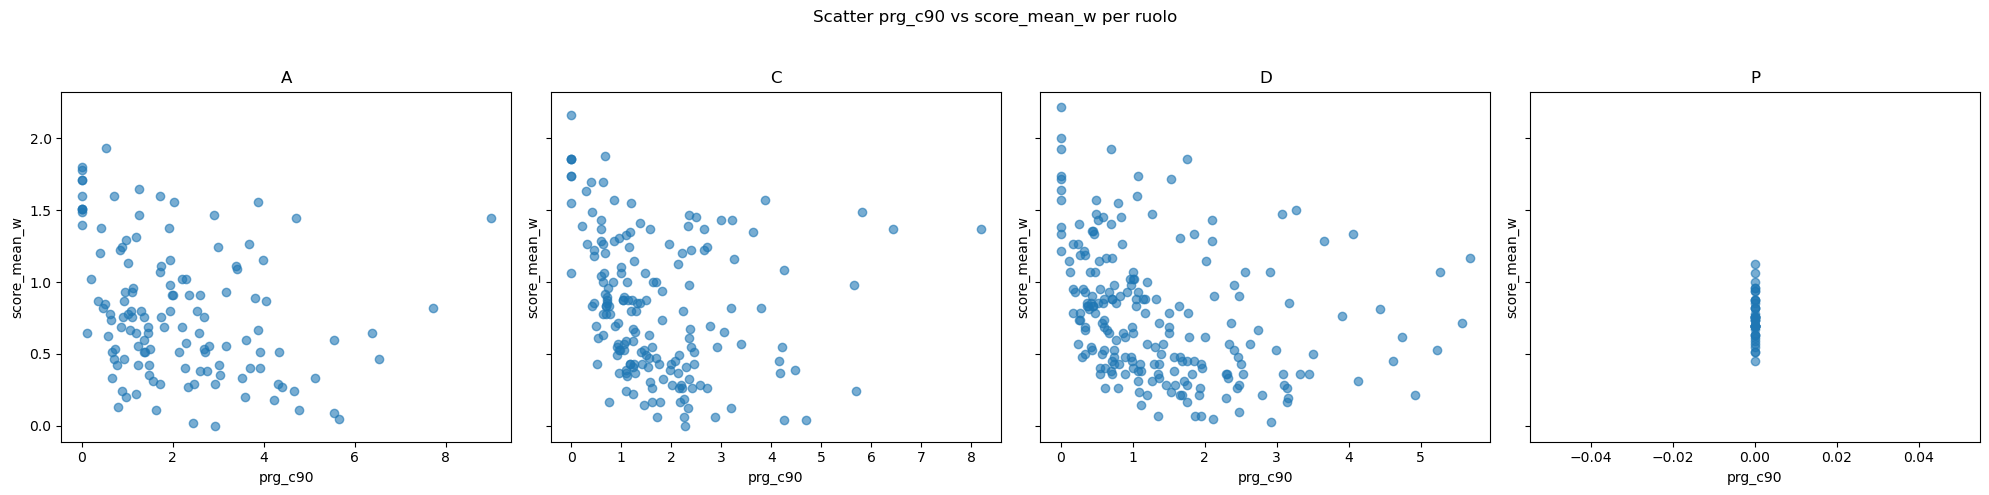

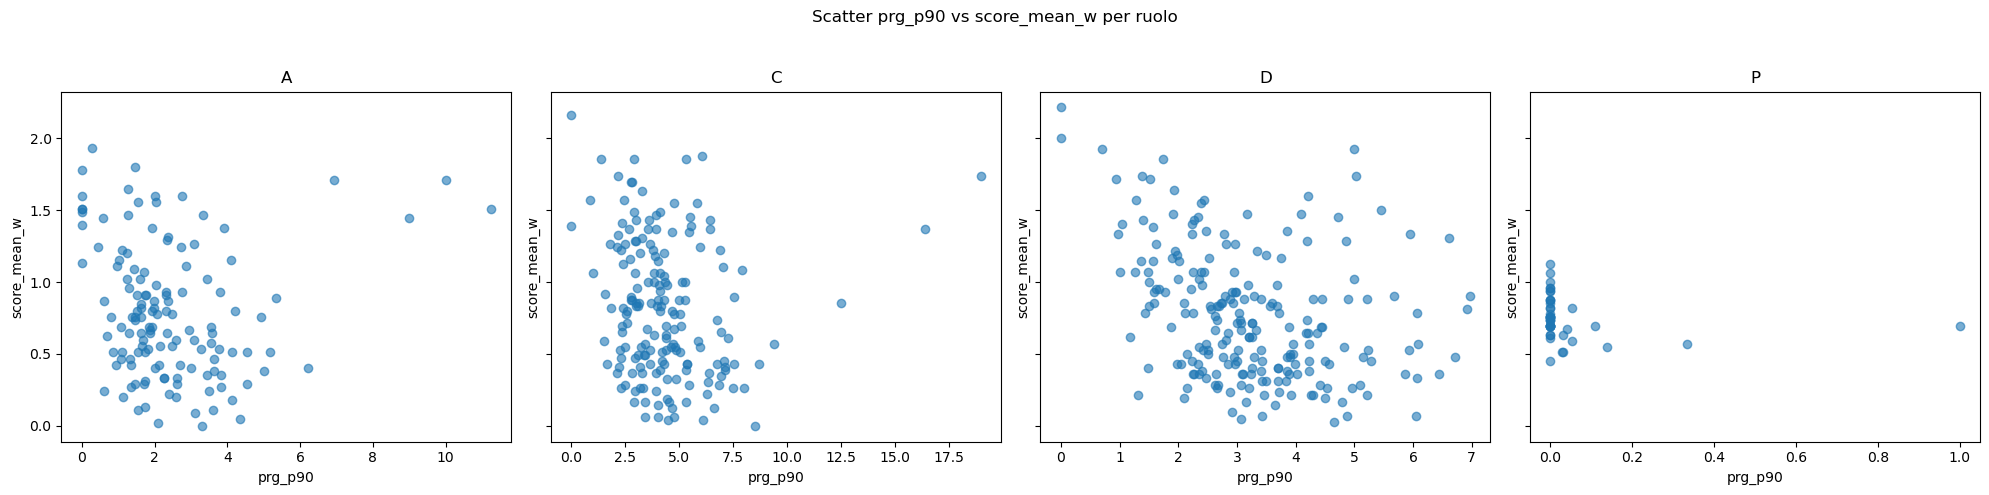

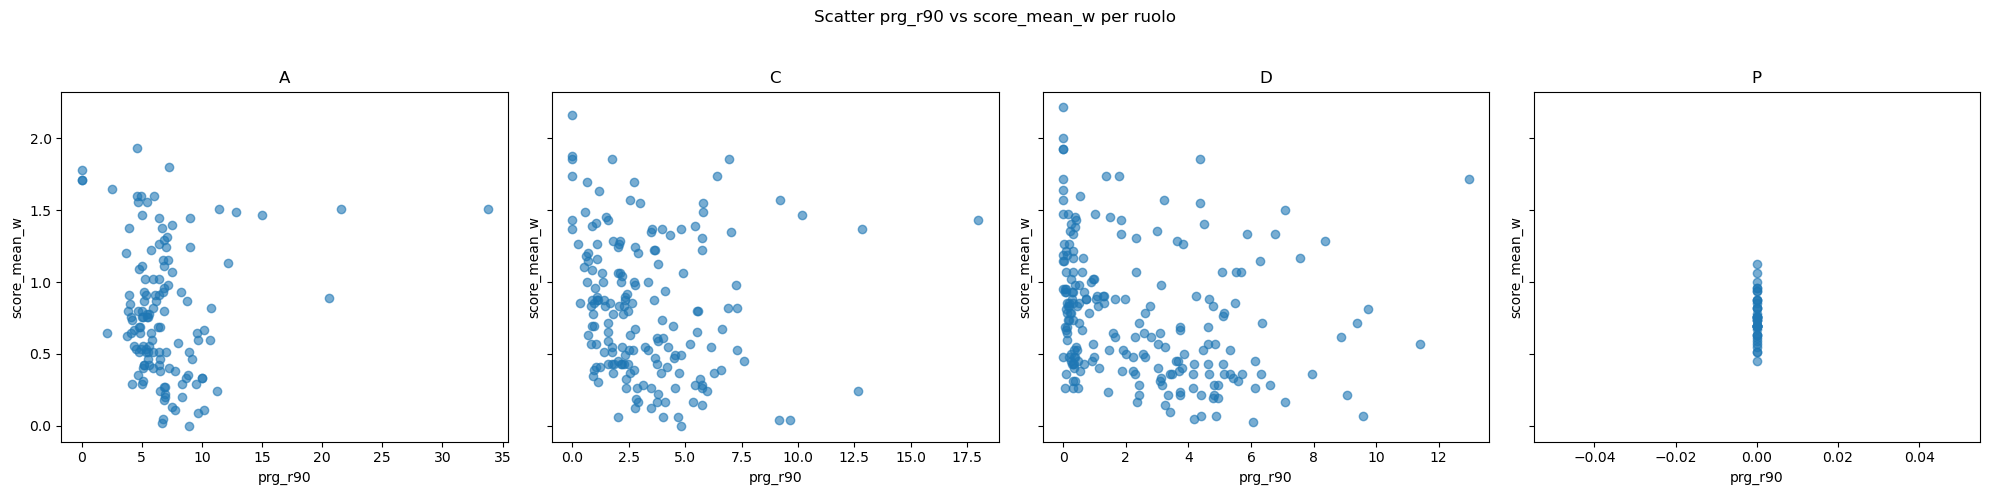

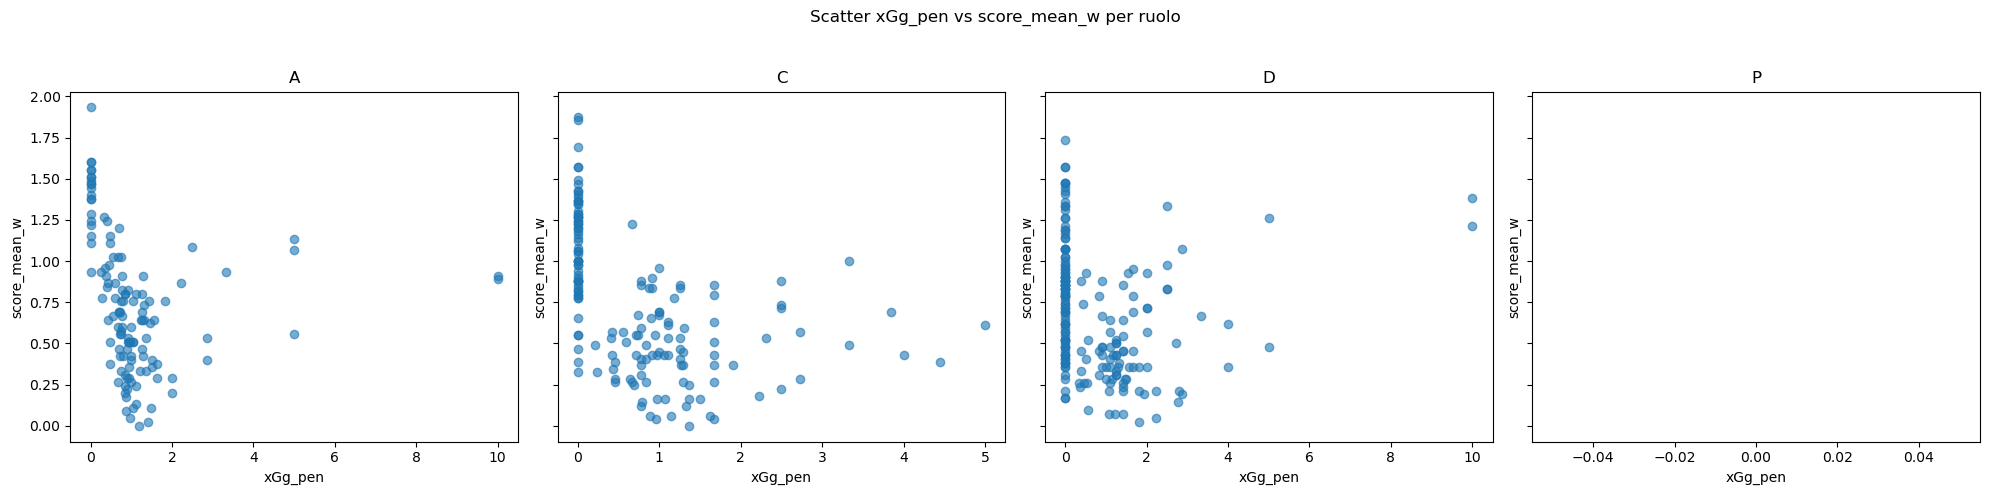

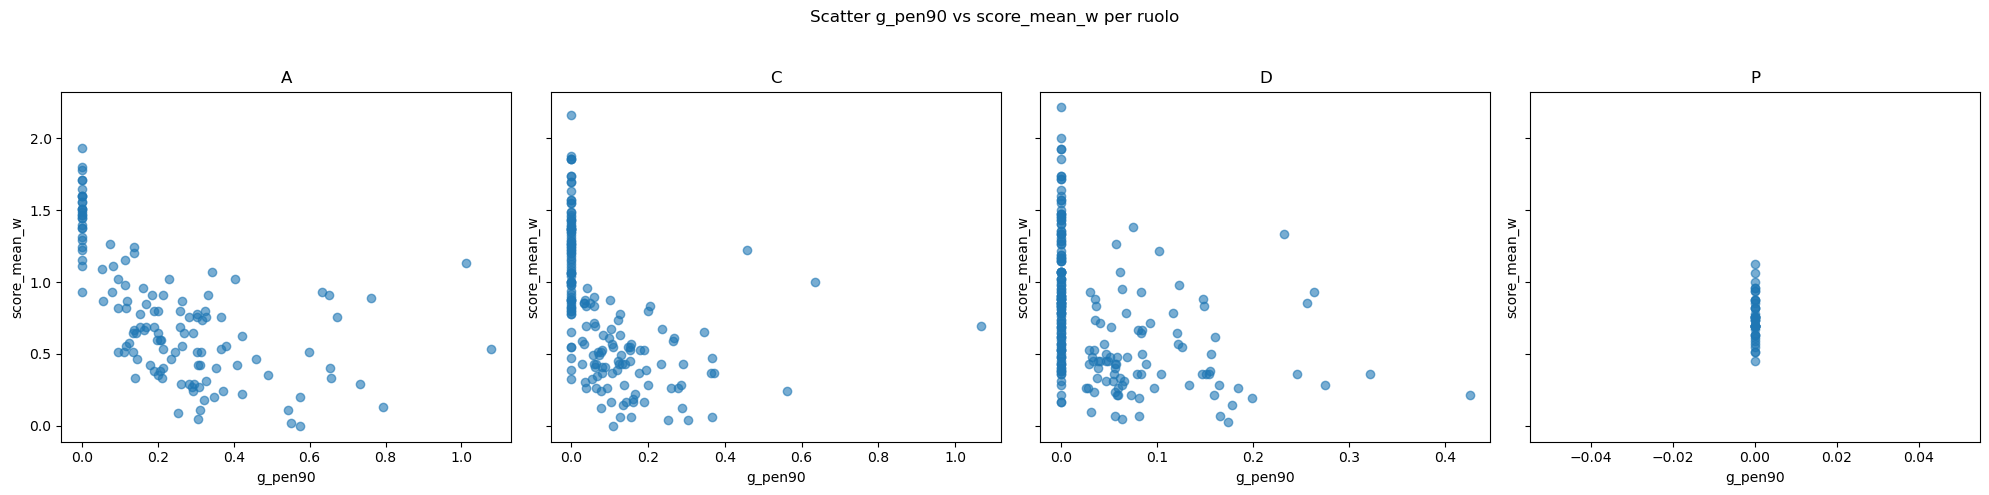

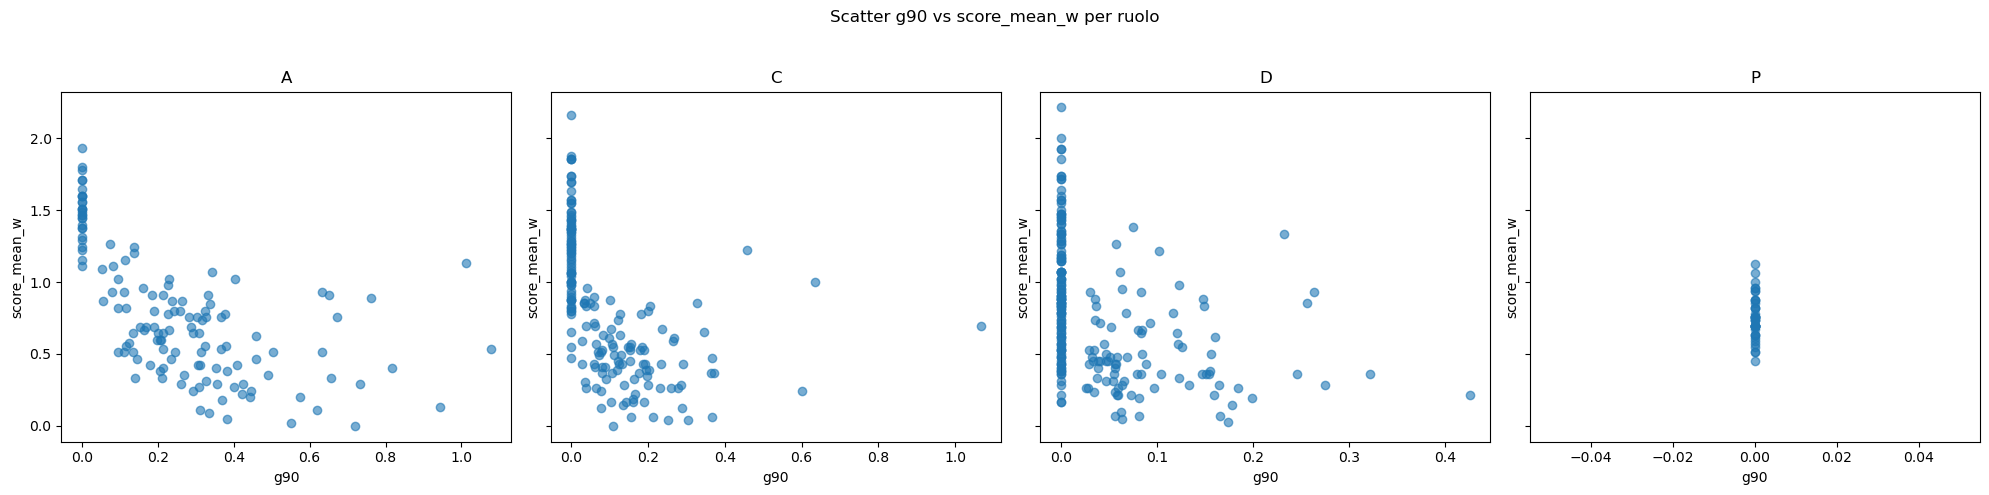

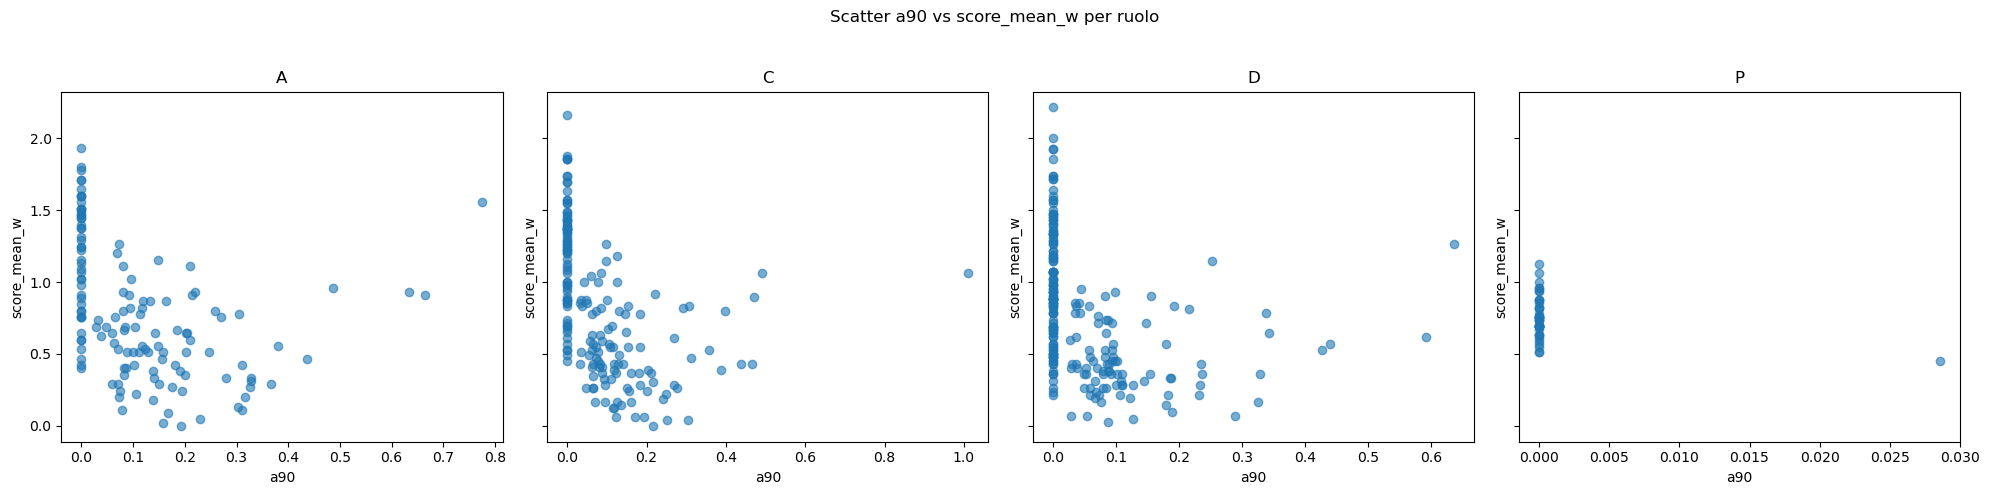

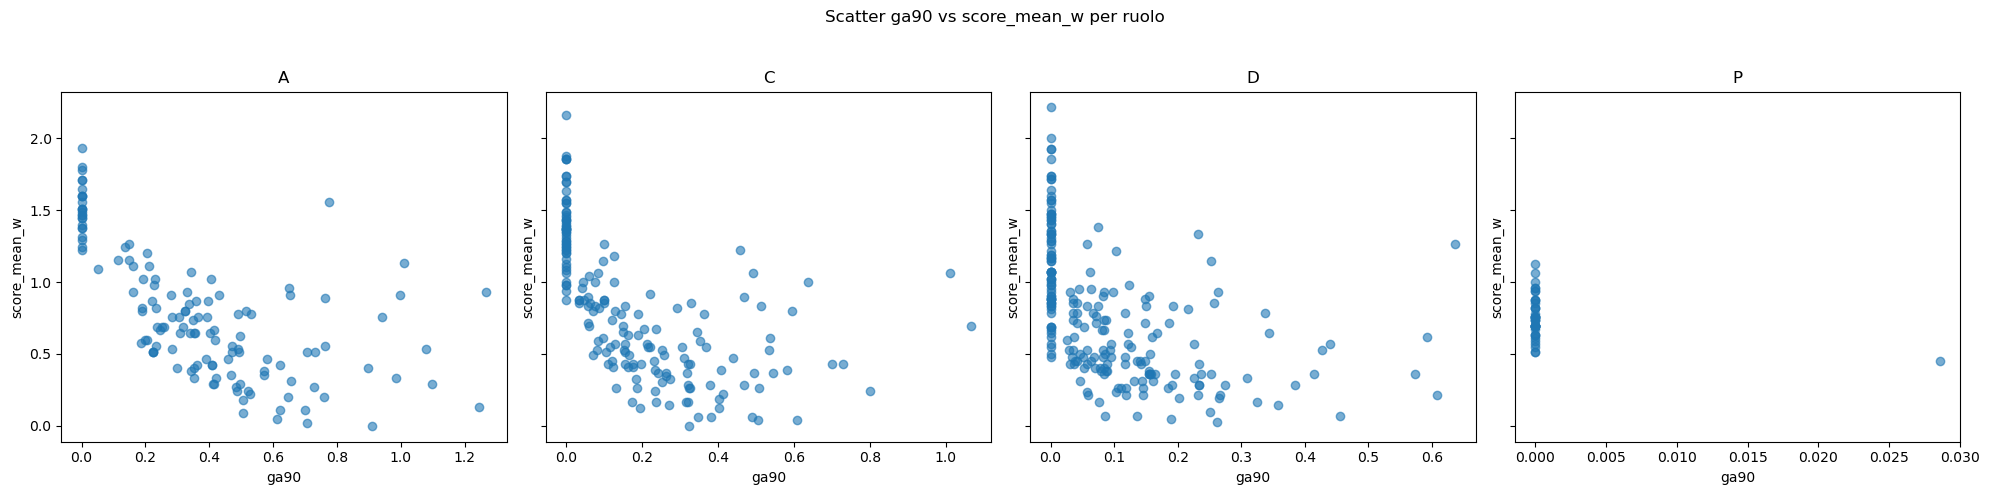

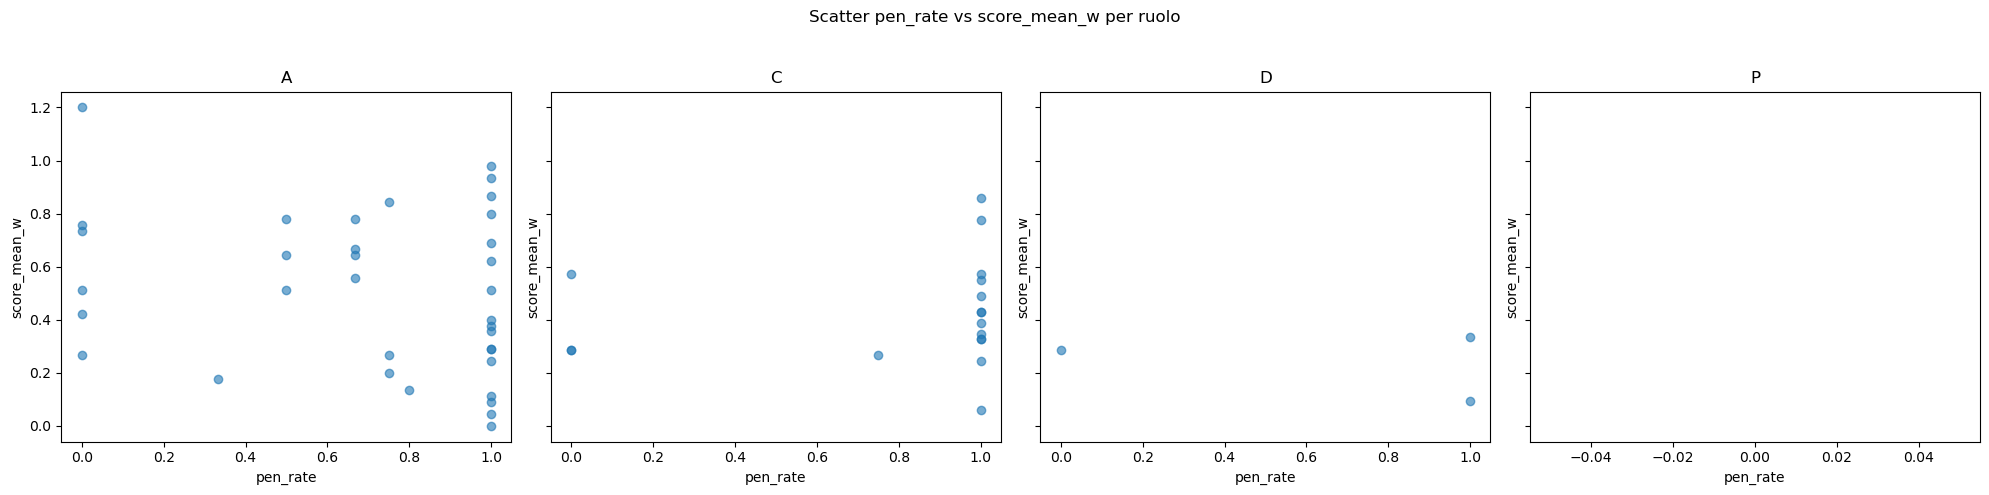

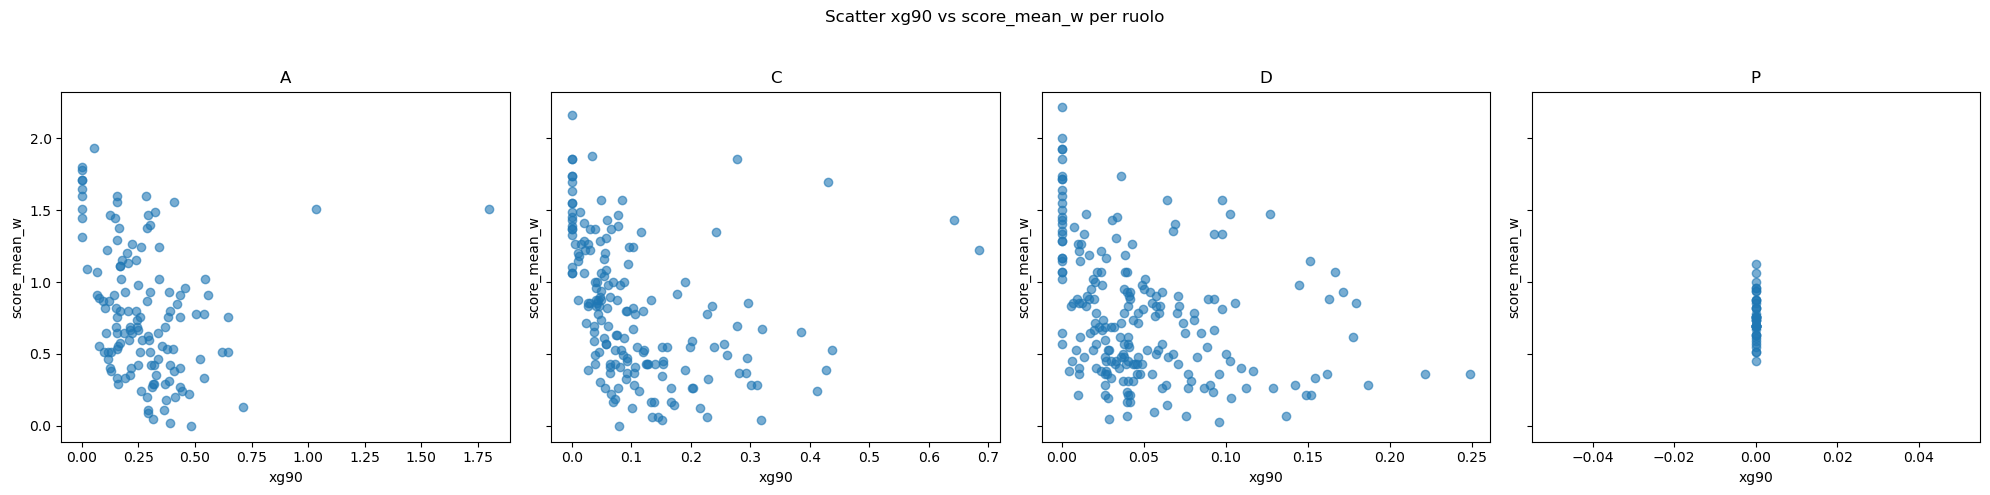

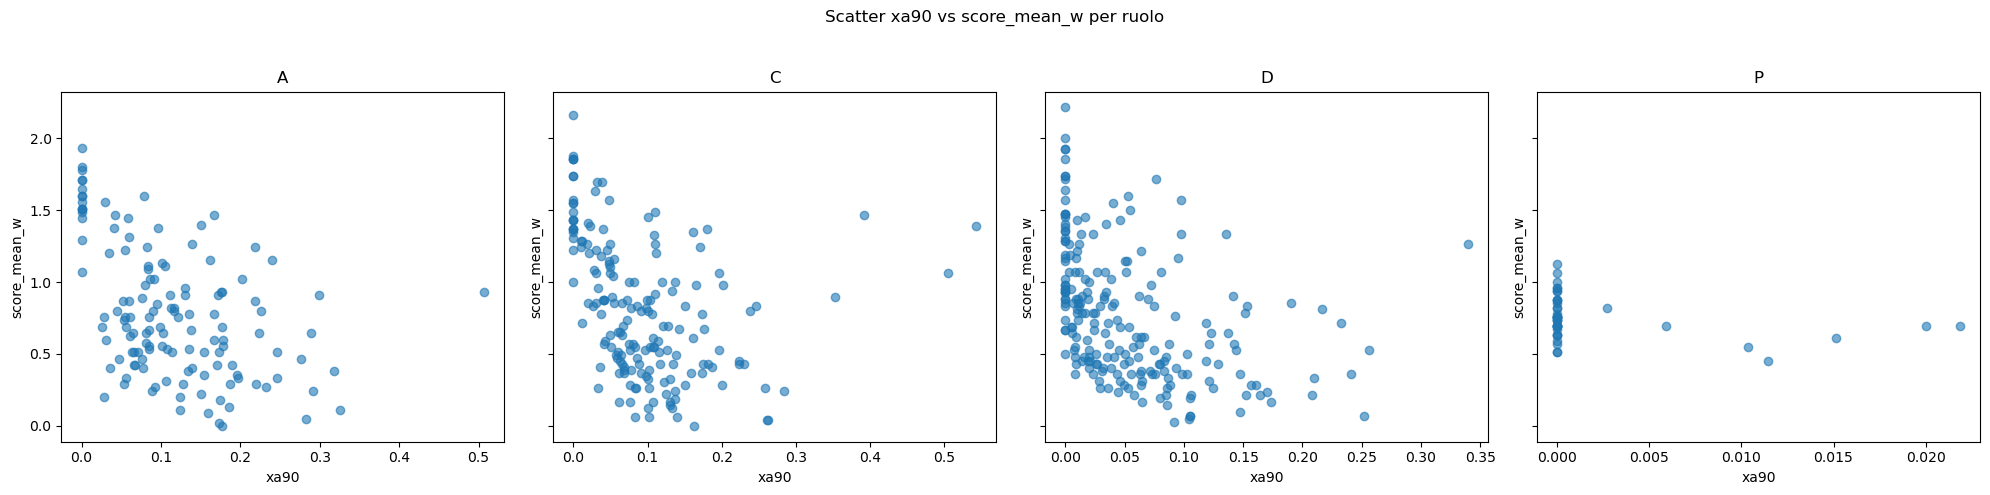

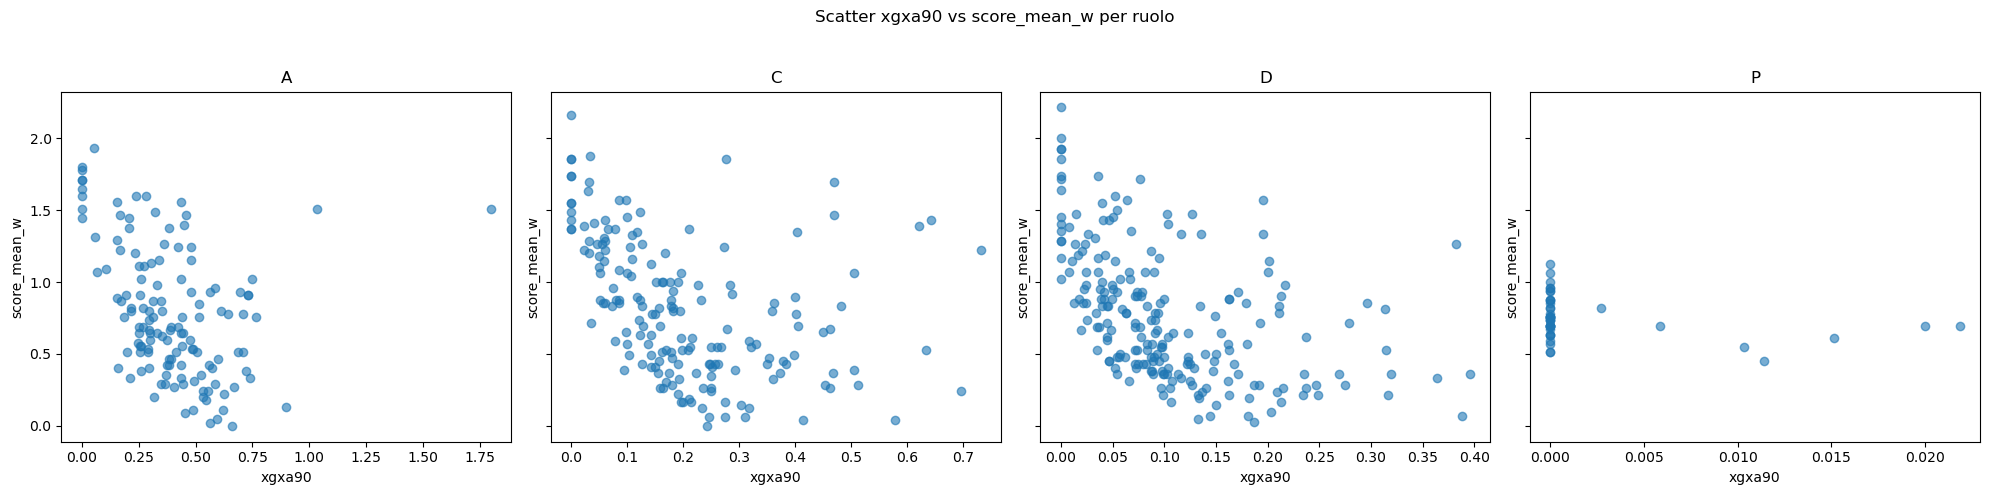

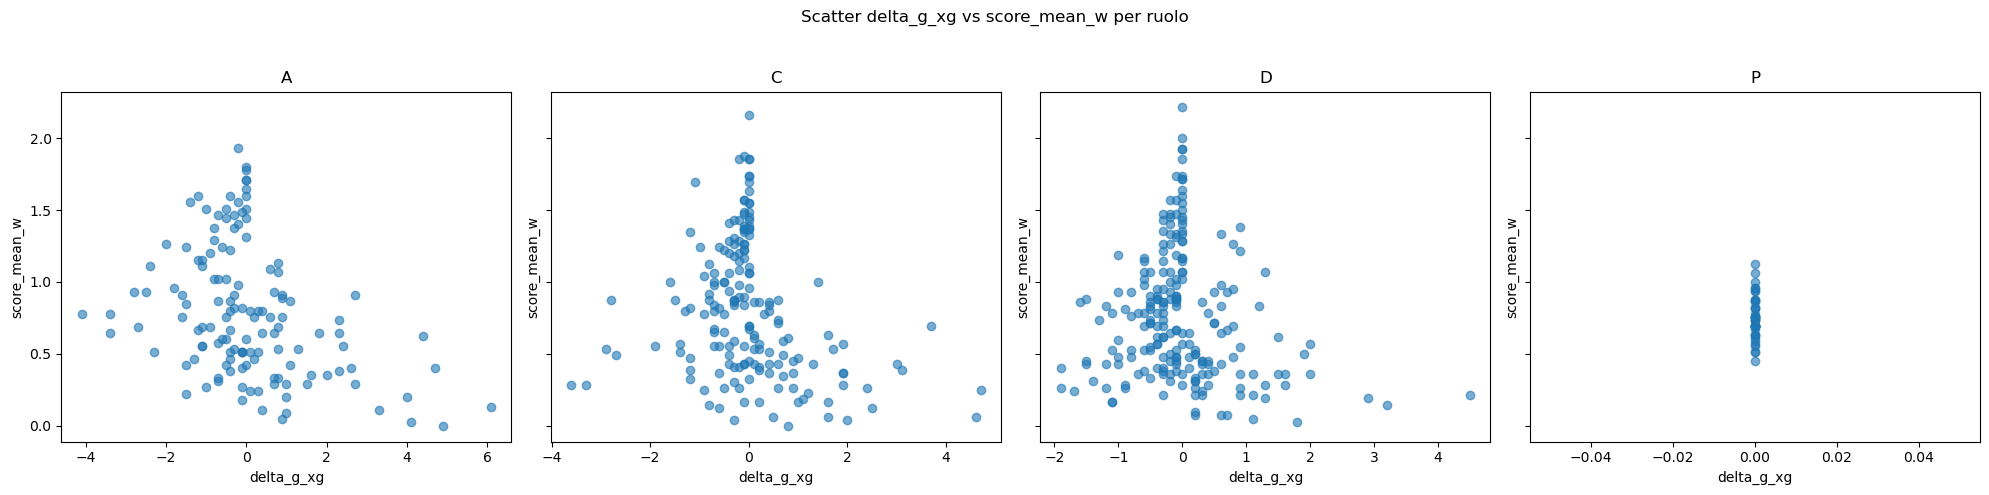

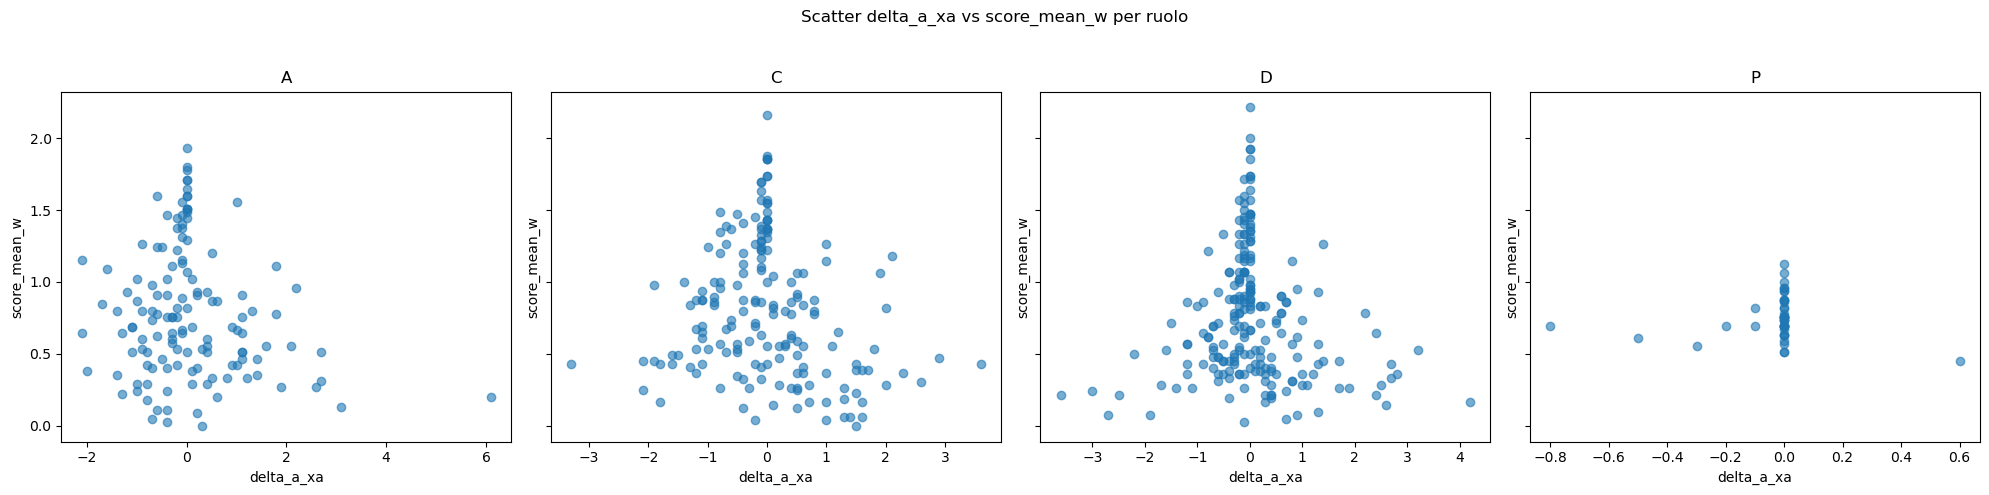

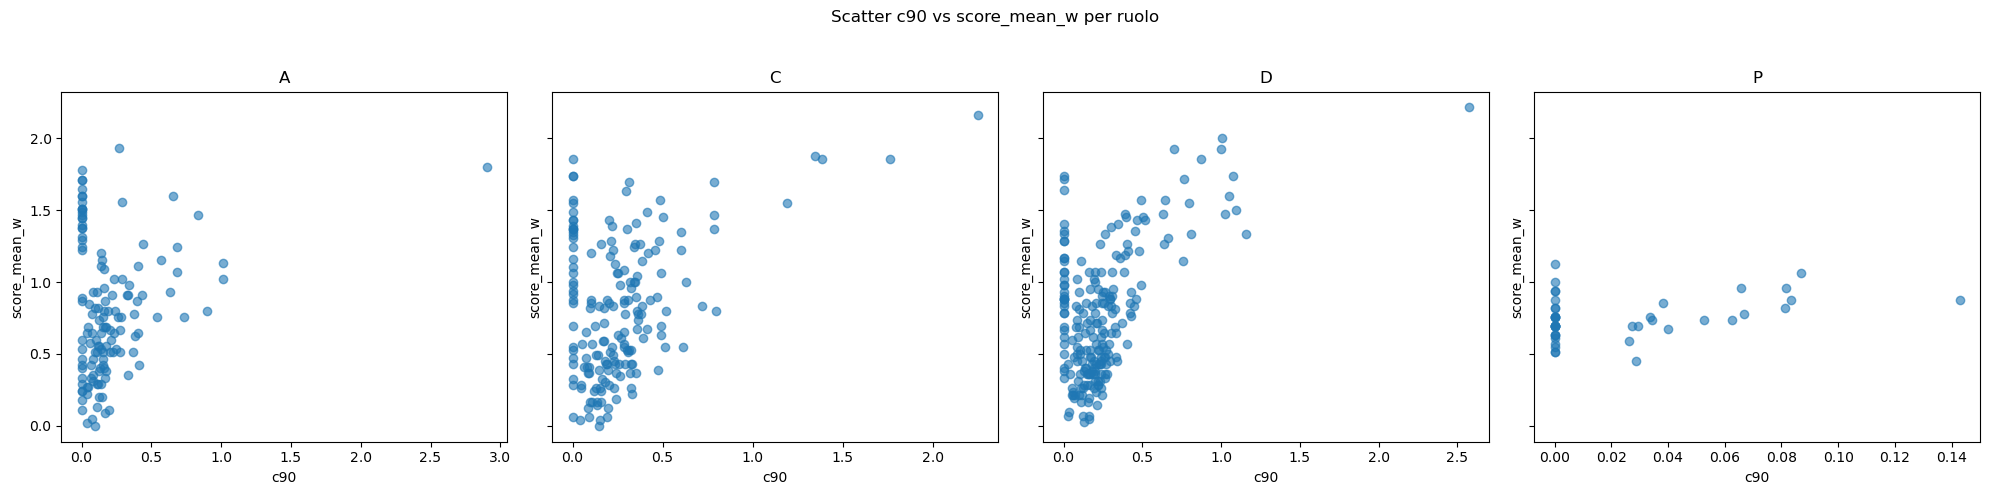

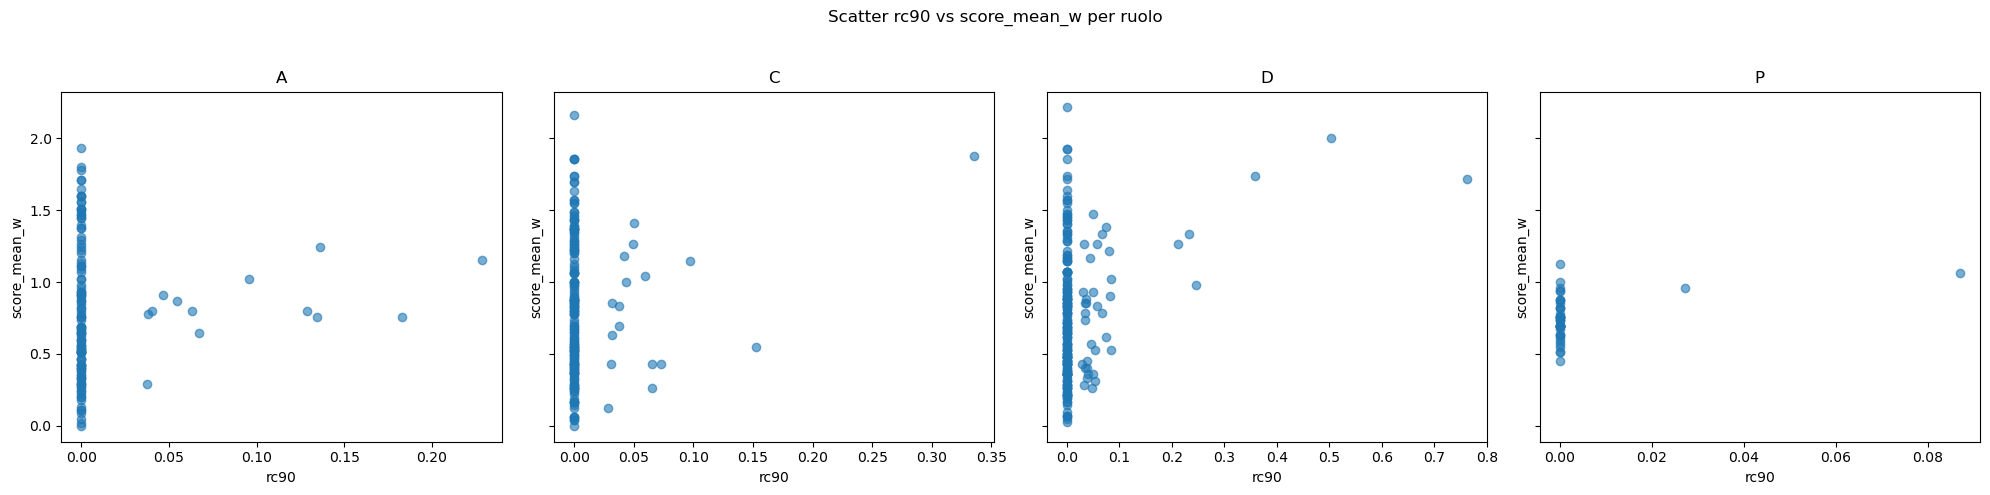

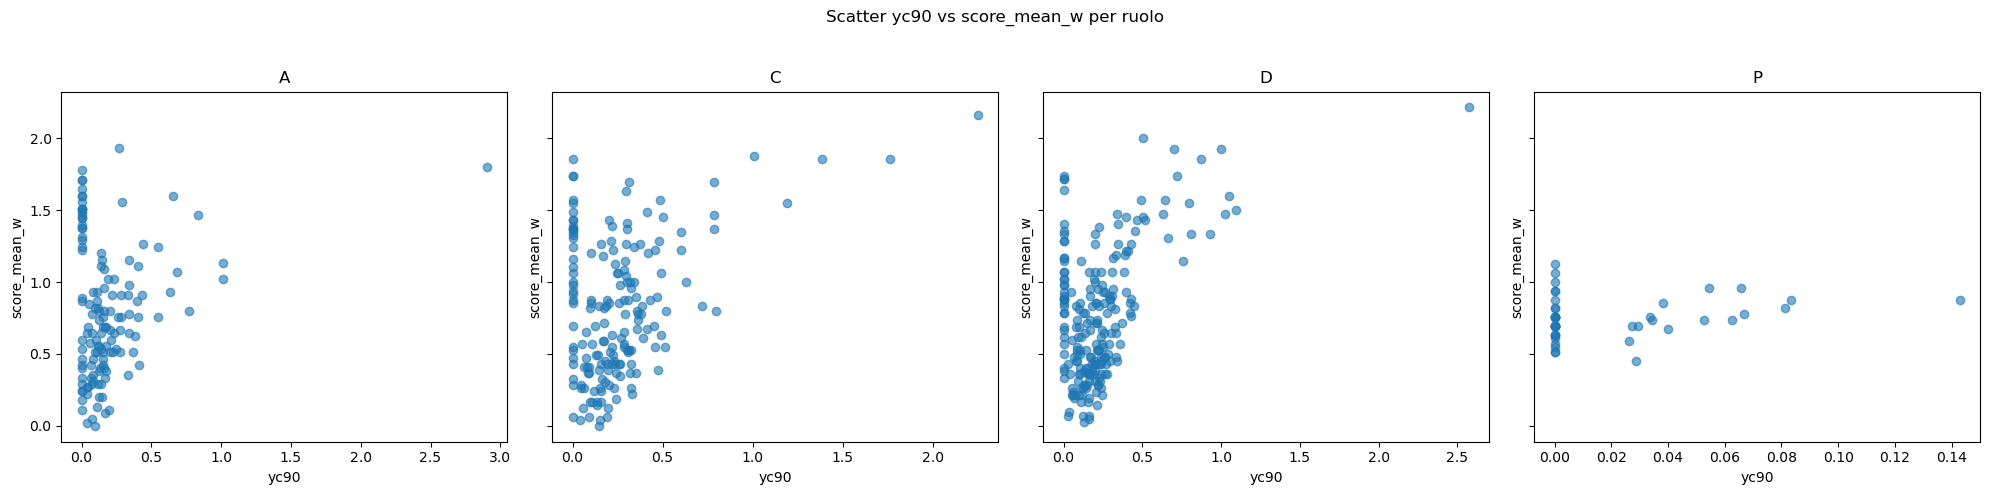

In [7]:
def scatter_by_role(df, xcol, ycol="score_mean_w"):
    """
    Crea uno scatter plot score vs metrica, diviso per ruolo.
    """
    roles = df["pos"].dropna().unique()
    n_roles = len(roles)

    fig, axes = plt.subplots(1, n_roles, figsize=(5*n_roles,5), sharey=True)

    if n_roles == 1:
        axes = [axes]  # rende sempre iterabile

    for ax, r in zip(axes, roles):
        sub = df[df["pos"]==r]
        ax.scatter(sub[xcol], sub[ycol], alpha=0.6)
        ax.set_title(f"{r}")
        ax.set_xlabel(xcol)
        ax.set_ylabel(ycol)

    plt.suptitle(f"Scatter {xcol} vs {ycol} per ruolo")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

list = [
    "first_ch", "first_pl", "pres", 
    "prg_c90", "prg_p90", "prg_r90", 
    "xGg_pen", "g_pen90", "g90", "a90", "ga90", "pen_rate",
    "xg90", "xa90", "xgxa90",
    "delta_g_xg", "delta_a_xa",
    "c90", "rc90", "yc90"
]
for stat in list:
    scatter_by_role(df_rank, stat)

## 8.	Ranking & Tier

In [16]:
# C# Assumo che df_rank contenga: player, pos, tier_overall, score_mean_w
# Creo/aggiorno lo score 0–100
df_rank = df_rank.copy()

df_fantacalcio = pd.read_csv("Dati/Statistiche_Fantacalcio_Stagione_2025_26.csv", encoding="latin1", sep=";")
df_fantacalcio = df_fantacalcio.drop(columns=[
    'Id','Rm','Pv', 'Mv', 'Fm', 'Gf', 'Gs', 'Rp', 'Rc', 'R+', 'R-', 'Ass', 'Amm', 'Esp', 'Au'
])
def pulisci_cognome(nome: str) -> str:
    if pd.isna(nome):
        return nome
    # rimuove iniziali finali tipo " M." o " Ad."
    nome = re.sub(r"\s+[A-Z][a-z]?\.$", "", nome)  
    return nome.strip()

df_fantacalcio["Nome"] = df_fantacalcio["Nome"].apply(pulisci_cognome)

map_squadra = {
    (row["Nome"]): row["Squadra"]
    for _, row in df_fantacalcio.iterrows()
}

squadre = []
for _, row in df_rank.iterrows():
    key = (row["player"])   # chiave nome + ruolo
    squadre.append(map_squadra.get(key, None))  # None se non trovato

df_rank["squadra2526"] = squadre

df_rank["score_0_100"] = (df_rank["score_mean_w"] / 3 * 100).round(1)

# Ordini desiderati
role_order  = {"P": 0, "D": 1, "C": 2, "A": 3}
tier_order  = {"S": 0, "A": 1, "B": 2, "C": 3}

# Colonne output
col_rename = {
    # --- Identità ---
    "player": "Giocatore",
    "pos": "Ruolo",
    "squadra2526": "Squadra",

    # --- Metriche base (per 90 minuti) ---
    "g90": "Gol/90",
    "a90": "Assist/90",
    "ga90": "Gol+Assist/90",
    "xg90": "Gol/90 attesi",
    "xa90": "Assist/90 attesi",
    "xgxa90": "Gol+Assist/90 attesi",

    # --- Metriche avanzate ---
    "first_ch": "Occasioni create",
    "first_pl": "Passaggi chiave",
    "pres": "Pressioni",
    "prg_c90": "Progressioni palla (Carry/90)",
    "prg_p90": "Progressioni palla (Pass/90)",
    "prg_r90": "Progressioni palla (Ricezione/90)",
    "xGg_pen": "xG senza rigori",
    "g_pen90": "Gol senza rigori/90",
    "pen_rate": "Percentuale rigori",
    "delta_g_xg": "Differenza Gol fatti - attesi",
    "delta_a_xa": "Differenza Assist fatti - attesi",

    # --- Metriche negative ---
    "c90": "Cartellini/90",
    "rc90": "Espulsioni/90",
    "yc90": "Ammonizioni/90",

    # --- Output sintetici ---
    "score_mean_w": "Indice Sintetico",
    "score_0_100": "Punteggio (0-100)",
    "score_pct_role": "Percentile nel Ruolo",
    "tier_overall": "Tier",

     # --- Metriche base (per 90 minuti) ---
    "g90_grade": "Tier Gol/90",
    "a90_grade": "Tier Assist/90",
    "ga90_grade": "Tier Gol+Assist/90",
    "xg90_grade": "Tier xG/90",
    "xa90_grade": "Tier xA/90",
    "xgxa90_grade": "Tier xG+xA/90",

    # --- Metriche avanzate ---
    "first_ch_grade": "Tier Occasioni create",
    "first_pl_grade": "Tier Passaggi chiave",
    "pres_grade": "Tier Pressioni",
    "prg_c90_grade": "Tier Progressioni palla (Carry/90)",
    "prg_p90_grade": "Tier Progressioni palla (Pass/90)",
    "prg_r90_grade": "Tier Progressioni palla (Ricezione/90)",
    "xGg_pen_grade": "Tier xG senza rigori",
    "g_pen90_grade": "Tier Gol senza rigori/90",
    "pen_grade": "Tier Percentuale rigori",
    "delta_g_xg_grade": "Tier Differenza Gol-xG",
    "delta_a_xa_grade": "Tier Differenza Assist-xA",

    # --- Metriche negative ---
    "c90_grade": "Tier Cartellini/90",
    "rc90_grade": "Tier Espulsioni/90",
    "yc90_grade": "Tier Ammonizioni/90",
}

col_export = [
    # --- Identità ---
    "Giocatore","Ruolo","Squadra",

    # --- Metriche base (per 90 minuti) ---
    "Gol/90","Assist/90","Gol+Assist/90","Gol/90 attesi", "Assist/90 attesi", "Gol+Assist/90 attesi",

    # --- Metriche avanzate ---
    "Occasioni create","Passaggi chiave","Pressioni","Progressioni palla (Carry/90)",
    "Progressioni palla (Pass/90)","Progressioni palla (Ricezione/90)","xG senza rigori",
    "Gol senza rigori/90","Percentuale rigori","Differenza Gol fatti - attesi","Differenza Assist fatti - attesi",

    # --- Metriche negative ---
    "Cartellini/90","Espulsioni/90","Ammonizioni/90",

    # --- Output sintetici ---
    "Indice Sintetico","Punteggio (0-100)","Percentile nel Ruolo","Tier"
]

col_export2 = [
    # --- Identità ---
    "Giocatore","Ruolo","Squadra",
    
    "Tier Gol/90",
    "Tier Assist/90",
    "Tier Gol+Assist/90",
    "Tier xG/90",
    "Tier xA/90",
    "Tier xG+xA/90",

    "Tier Occasioni create",
    "Tier Passaggi chiave",
    "Tier Pressioni",
    "Tier Progressioni palla (Carry/90)",
    "Tier Progressioni palla (Pass/90)",
    "Tier Progressioni palla (Ricezione/90)",
    "Tier xG senza rigori",
    "Tier Gol senza rigori/90",
    "Tier Differenza Gol-xG",
    "Tier Differenza Assist-xA",

    "Tier Cartellini/90",
    "Tier Espulsioni/90",
    "Tier Ammonizioni/90"
]
# Mappature d’ordinamento
df_export = df_rank.rename(columns=col_rename).copy().round(2)
df_export["role_sort"] = df_export["Ruolo"].map(role_order)
df_export["tier_sort"] = df_export["Tier"].map(tier_order)

# Ordinamento: ruolo → tier → score decrescente → nome
df_export = (
    df_export.sort_values(
        by=["role_sort", "tier_sort", "Punteggio (0-100)", "Giocatore", "Squadra"],
        ascending=[True, False, True, True, True]
    )
    .drop(columns=["role_sort", "tier_sort"])
)

# Salva
os.makedirs("OutputCSV", exist_ok=True)
path_ranked = os.path.join("OutputCSV", "giocatori_per_ruolo_rank.csv")
df_export[col_export].to_csv(path_ranked, index=False, encoding="utf-8-sig")
print(f"Salvato: {path_ranked}")
path_ranked2 = os.path.join("OutputCSV", "giocatori_per_ruolo_rank_tier.csv")
df_export[col_export2].to_csv(path_ranked2, index=False, encoding="utf-8-sig")
print(f"Salvato: {path_ranked2}")

df_alpha = df_export.copy()
df_alpha["role_sort"] = df_alpha["Ruolo"].map(role_order)

df_alpha = (
    df_alpha.sort_values(by=["role_sort", "Giocatore"], ascending=[True, True])
            .drop(columns=["role_sort"])
)

path_alpha = os.path.join("OutputCSV", "giocatori_per_ruolo_alfabetico.csv")
df_alpha[col_export].to_csv(path_alpha, index=False, encoding="utf-8-sig")
print(f"Salvato: {path_alpha}")
path_alpha2 = os.path.join("OutputCSV", "giocatori_per_ruolo_alfabetico_tier.csv")
df_alpha[col_export2].to_csv(path_alpha2, index=False, encoding="utf-8-sig")
print(f"Salvato: {path_alpha2}")

Salvato: OutputCSV/giocatori_per_ruolo_rank.csv
Salvato: OutputCSV/giocatori_per_ruolo_rank_tier.csv
Salvato: OutputCSV/giocatori_per_ruolo_alfabetico.csv
Salvato: OutputCSV/giocatori_per_ruolo_alfabetico_tier.csv


In [13]:
top10_att = (
    df_export[
    (df_export["Ruolo"]=="A") & (df_export["Squadra"].notna())
    ]
    .sort_values("Indice Sintetico", ascending=True)
    .head(10)
)
display(top10_att[["Giocatore", "Squadra", "Tier", "Gol/90", "Gol/90 attesi", "Differenza Gol fatti - attesi"]])

,Giocatore,Squadra,Tier,Gol/90,Gol/90 attesi,Differenza Gol fatti - attesi
109,Orsolini,Bologna,S,0.72,0.48,4.9
80,Thuram,Inter,S,0.55,0.39,4.1
31,Ndoye,Bologna,S,0.34,0.29,1.0
44,Thauvin,Udinese,S,0.37,0.37,-0.1
20,Diao,Como,S,0.58,0.29,4.0
112,Lukaku,Napoli,S,0.44,0.41,1.0
113,Chukwueze,Milan,S,0.29,0.26,0.3
19,Dovbyk,Roma,S,0.45,0.44,0.1
101,Cutrone,Como,A,0.31,0.31,-0.1
27,Pulisic,Milan,A,0.40,0.44,-1.0


In [14]:
top10_cen = (
    df_export[
    (df_export["Ruolo"]=="C") & (df_export["Squadra"].notna())
    ]
    .sort_values("Indice Sintetico", ascending=True)
    .head(10)
)
display(top10_cen[["Giocatore", "Squadra", "Tier", "Assist/90", "Assist/90 attesi", "Differenza Assist fatti - attesi"]])

,Giocatore,Squadra,Tier,Assist/90,Assist/90 attesi,Differenza Assist fatti - attesi
252,Barella,Inter,S,0.22,0.16,1.5
154,De Ketelaere,Atalanta,S,0.30,0.26,1.0
278,McTominay,Napoli,S,0.12,0.08,1.3
206,Thuram,Inter,S,0.19,0.14,1.4
288,Koopmeiners,Juventus,S,0.14,0.13,0.1
218,Da Cunha,Como,S,0.07,0.13,-1.8
201,Ekkelenkamp,Udinese,S,0.10,0.06,0.7
170,Miretti,Juventus,S,0.16,0.11,1.0
143,Zambo Anguissa,Napoli,S,0.13,0.08,1.6
171,Anjorin,Torino,S,0.24,0.14,1.3


In [15]:
top10_cen = (
    df_export[
    (df_export["Ruolo"]=="D") & (df_export["Squadra"].notna())
    ]
    .sort_values("Indice Sintetico", ascending=True)
    .head(10)
)
display(top10_cen[["Giocatore", "Squadra", "Tier", "Gol/90", "Assist/90","Cartellini/90", "Espulsioni/90", "Ammonizioni/90",]]) 

,Giocatore,Squadra,Tier,Gol/90,Assist/90,Cartellini/90,Espulsioni/90,Ammonizioni/90
357,Zappacosta,Atalanta,S,0.17,0.09,0.13,0.0,0.13
392,Di Lorenzo,Napoli,S,0.08,0.05,0.16,0.0,0.16
375,Dimarco,Inter,S,0.17,0.29,0.12,0.0,0.12
365,Valeri,Parma,S,0.06,0.19,0.03,0.0,0.03
485,Gosens,Fiorentina,S,0.18,0.18,0.21,0.0,0.21
481,Bellanova,Atalanta,S,0.00,0.33,0.11,0.0,0.11
446,Olivera,Napoli,S,0.00,0.08,0.15,0.0,0.15
328,Cambiaso,Juventus,S,0.08,0.12,0.16,0.0,0.16
459,Zortea,Bologna,S,0.20,0.07,0.07,0.0,0.07
457,Ellertsson,Genoa,S,0.07,0.07,0.07,0.0,0.07
